# Test the use of the `uncertainties` package for error propogation

We compare two methods of propogating errors:
1. Manual calculation/propogation of value and error separately (Melissa's work)
2. Using `uncertainties`, which calculates/propogates values/errors altogether for you (Midori's implementation)

We investigate the differences in final values of a few parameters between theses methods.

## Set up and read in data

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainties as unc  
import uncertainties.unumpy as unp
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

Read in the `sncosmo` results.

The fit peak magnitudes are read in but not used in this notebook.

In [2]:
fnm = 'all_fit_snia_files/results_sncosmos.dat'

fit_cand = np.loadtxt(fnm, dtype='str', usecols=(0))
fit_est_z = np.loadtxt(fnm, dtype='float', usecols=(1))
fit_in_zlo = np.loadtxt(fnm, dtype='float', usecols=(2))
fit_in_zhi = np.loadtxt(fnm, dtype='float', usecols=(3))
fit_z = np.loadtxt(fnm, dtype='float', usecols=(4))
fit_ze = np.loadtxt(fnm, dtype='float', usecols=(5))
fit_t0 = np.loadtxt(fnm, dtype='float', usecols=(6))
fit_t0e = np.loadtxt(fnm, dtype='float', usecols=(7))
fit_x0 = np.loadtxt(fnm, dtype='float', usecols=(8))
fit_x0e = np.loadtxt(fnm, dtype='float', usecols=(9))
fit_x1 = np.loadtxt(fnm, dtype='float', usecols=(10))
fit_x1e = np.loadtxt(fnm, dtype='float', usecols=(11))
fit_c = np.loadtxt(fnm, dtype='float', usecols=(12))
fit_ce = np.loadtxt(fnm, dtype='float', usecols=(13))

fit_pmB = np.loadtxt(fnm, dtype='float', usecols=(14))
fit_pmg = np.loadtxt(fnm, dtype='float', usecols=(15))
fit_pmr = np.loadtxt(fnm, dtype='float', usecols=(16))
fit_pmi = np.loadtxt(fnm, dtype='float', usecols=(17))

del fnm

Creating flags so we can look at just the candidates w/ good fits/values

In [3]:
fnm = 'all_fit_snia_files/results_sncosmos_fit_review.dat'
fit_flag = np.loadtxt(fnm, dtype='int', usecols=(1))
fit_flagMR = np.loadtxt(fnm, dtype='int', usecols=(2))
del fnm

> 'fit_[**parameter**]'& 'fit_[**parametere**]e' indicates separate value & error calculations, done by Melissa (eg. fit_x0; array containing just x0 values, and fit_x0e; array containing just x0 errors)

> '[**parameter**]' indicates use of uncertainties package (eg. x0; uarray containing both nominal and error values of x0)

> fit_x0, fit_x1, fit_c, fit_z, fit_pmB & corresponding errors are all derived from sncosmo, so no manual calculation necessary. x0, x1, color, z & mB are values/errors from sncosmo itself

>dm15 & dm15e, s & se, mBe are calculated using uncertainties package

>fit_dm15, fit_s, fit_MB & respective error arrays are manual error propogation

The only meaningful relationships we should find are for mBe, as well as delta_m15, stretch, and their corresponding errors. These are the only parameters that we actually use uncertainties package for (x1 is unp.array()). We cannot put an unp.array() through the cosmology package. 

In [4]:
# x0
x0 = unp.uarray((fit_x0, abs(fit_x0e)))

# x1
x1 = unp.uarray((fit_x1, abs(fit_x1e)))

/tmp/ipykernel_1562429/1424468453.py:2: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  x0 = unp.uarray((fit_x0, abs(fit_x0e)))
/tmp/ipykernel_1562429/1424468453.py:5: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  x1 = unp.uarray((fit_x1, abs(fit_x1e)))


In [5]:
# dm15
dm15 = 1.09 - 0.161*x1 + 0.013*x1**2 - 0.00130*x1**3

# fit_dm15
fit_dm15 = 1.09 - 0.161*fit_x1 + 0.013*fit_x1**2 - 0.00130*fit_x1**3

# fit_dm15e
fit_dm15e = np.zeros(len(fit_dm15), dtype='float')
for c in range(len(fit_dm15)):
    if fit_x1e[c] > 0:
        temp = np.random.normal(loc=fit_x1[c], scale=fit_x1e[c], size=10000)
        temp2 = 1.09 - 0.161*temp + 0.013*temp**2 - 0.00130*temp**3
        fit_dm15e[c] = np.std(temp2)
        del temp, temp2
    else:
        fit_dm15e[c] = -99.9

In [6]:
# s
s = 0.98 + 0.091*x1 + 0.003*x1**2 - 0.00075*x1**3

# fit_s
fit_s = 0.98 + 0.091*fit_x1 + 0.003*fit_x1**2 - 0.00075*fit_x1**3

#fit_se
fit_se = np.zeros(len(fit_s), dtype='float')
for c in range(len(fit_s)):
    if fit_x1e[c] > 0:
        temp = np.random.normal(loc=fit_x1[c], scale=fit_x1e[c], size=10000)
        temp2 = 0.98 + 0.091*temp + 0.003*temp**2 - 0.00075*temp**3
        fit_se[c] = np.std(temp2)
        del temp, temp2
    else:
        fit_se[c] = -99.9

In [7]:
# fit_pmfe
fit_pmfe = np.zeros(len(fit_x0e), dtype='float')
for c in range(len(fit_x0e)):
    if fit_x0e[c] > 0:
        temp = np.random.normal(loc=fit_x0[c], scale=fit_x0e[c], size=10000)
        temp2 = -2.5 * np.log10(temp) + 10.635
        fit_pmfe[c] = np.std(temp2)
        del temp, temp2
    else:
        fit_pmfe[c] = -99.9

/tmp/ipykernel_1562429/1521408878.py:6: RuntimeWarning: invalid value encountered in log10
  temp2 = -2.5 * np.log10(temp) + 10.635


In [8]:
# pmB
unp_pmfe = np.zeros(len(x0), dtype='float')
for c in range(len(x0)):
    if x0[c] > 0:
        temp = -2.5 * unp.log10(x0[c]) + 10.635
        unp_pmfe[c] = unp.std_devs(temp)
        del temp
    else:
        unp_pmfe[c] = -99.9
        
pmB = unp.uarray((fit_pmB, abs(unp_pmfe)))

/tmp/ipykernel_1562429/994376975.py:11: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  pmB = unp.uarray((fit_pmB, abs(unp_pmfe)))


### Plot relationships
* Derivation of parameter values look good, pretty much 1:1 relationship.

* Derivation of errors diverge from 1:1 relationship at larger values. Which method is to blame?

In [9]:
tx = np.where((fit_z > 0.0) & (fit_flagMR == 0))[0]

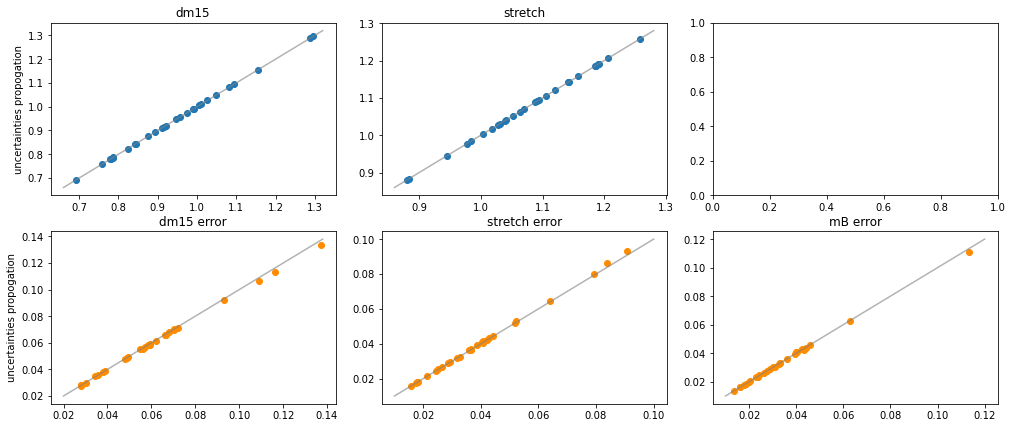

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6), sharex=False, sharey=False)
fig.tight_layout(pad=1.5)

ax[0,0].scatter(fit_dm15[tx], unp.nominal_values(dm15)[tx])
ax[0,0].set_title('dm15')
ax[0,0].set_ylabel('uncertainties propogation')
ax[0,0].plot([0.66, 1.32], [0.66, 1.32], ls='solid', lw=1.5, alpha=0.6, color='grey')
ax[1,0].scatter(fit_dm15e[tx], unp.std_devs(dm15)[tx], color='darkorange')
ax[1,0].set_title('dm15 error')
ax[1,0].set_ylabel('uncertainties propogation')
ax[1,0].plot([0.02, 0.138], [0.02, 0.138], ls='solid', lw=1.5, alpha=0.6, color='grey')
ax[0,1].scatter(fit_s[tx], unp.nominal_values(s)[tx])
ax[0,1].set_title('stretch')
ax[0,1].plot([0.86, 1.28], [0.86, 1.28], ls='solid', lw=1.5, alpha=0.6, color='grey')
ax[1,1].scatter(fit_se[tx], unp.std_devs(s)[tx],color='darkorange')
ax[1,1].set_title('stretch error')
ax[1,1].plot([0.01, 0.1], [0.01, 0.1], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[0,2].scatter(fit_pmB[tx], unp.nominal_values(pmB)[tx])
# ax[0,2].set_title('mB')
# ax[0,2].plot([20.2, 22.8], [20.2, 22.8], ls='solid', lw=1.5, alpha=0.6, color='grey')
ax[1,2].scatter(fit_pmfe[tx], unp.std_devs(pmB)[tx],color='darkorange')
ax[1,2].set_title('mB error')
ax[1,2].plot([0.01, 0.12], [0.01, 0.12], ls='solid', lw=1.5, alpha=0.6, color='grey')


plt.show()

Due to limitations with uncertainties package, at least in our particular situation, it's probably best to just manually calulate & propogate values/errors. Best to propogate error the same way for everything, especially since there does appear to be slight differences in error values between the two methods

In [53]:
# # fit_MB
# fit_MB = np.zeros(len(fit_pmB), dtype='float')
# tx = np.where(fit_z > 0.0)[0]
# fit_MB[tx] = fit_pmB[tx] - (5. * np.log10(cosmo.luminosity_distance(fit_z[tx]).value) + 25.)
# del tx

In [54]:
# # fit_MBe
# fit_MBe = np.zeros(len(fit_MB), dtype='float')
# for c in range(len(fit_MB)):
#     if fit_z[c] > 0.0:
#         temp = np.random.normal(loc=fit_z[c], scale=fit_ze[c], size=10000)
#         temp2 = np.random.normal(loc=fit_pmB[c], scale=fit_pmfe[c], size=10000)
#         temp3 = temp2 - (5. * np.log10(cosmo.luminosity_distance(temp).value) + 25.)
#         fit_MBe[c] = np.std(temp3)
#         del temp, temp2, temp3
#     else:
#         fit_MBe[c] = -99.9

In [55]:
# # MB
# unp_MB = np.zeros(len(unp.nominal_values(pmB)), dtype='float')
# tx = np.where(z > 0.0)[0]
# unp_MB[tx] = unp.nominal_values(pmB)[tx] - (5. * np.log10(cosmo.luminosity_distance(unp.nominal_values(z)[tx]).value) + 25.)
# del tx

# unp_MBe = np.zeros(len(unp.nominal_values(unp_MB)), dtype='float')
# for c in range(len(unp.nominal_values(unp_MB))):
#     if unp.nominal_values(z)[c] > 0.0:
#         temp = np.random.normal(loc=unp.nominal_values(z)[c], scale=unp.std_devs(z)[c], size=10000)
#         temp2 = np.random.normal(loc=unp.nominal_values(pmB)[c], scale=unp.std_devs(pmB)[c], size=10000)
#         temp3 = temp2 - (5. * np.log10(cosmo.luminosity_distance(temp).value) + 25.)
#         unp_MBe[c] = np.std(temp3)
#         del temp, temp2, temp3
#     else:
#         unp_MBe[c] = -99.9
        
# MB = unp.uarray((unp_MB, abs(unp_MBe)))

In [56]:
# fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=False, sharey=False)
# fig.tight_layout(pad=1.5)
# ax[0,0].scatter(fit_x0[tx], unp.nominal_values(x0)[tx])
# ax[0,0].set_title('x0')
# ax[0,0].set_ylabel('uncertainties propogation')
# ax[0,0].plot([0.00001, 0.000125], [0.00001, 0.000125], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[1,0].scatter(fit_x0e[tx], unp.std_devs(x0)[tx])
# ax[1,0].set_title('x0e')
# ax[1,0].set_ylabel('uncertainties propogation')
# ax[1,0].plot([0.46e-6, 2.0e-6], [0.46e-6, 2.0e-6], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[0,1].scatter(fit_x1[tx], unp.nominal_values(x1)[tx])
# ax[0,1].set_title('x1')
# ax[0,1].plot([-1.4, 3.2], [-1.4, 3.2], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[1,1].scatter(fit_x1e[tx], unp.std_devs(x1)[tx])
# ax[1,1].set_title('x1e')
# ax[1,1].plot([0.15, 1.05], [0.15, 1.05], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[0,2].scatter(fit_c[tx], unp.nominal_values(color)[tx])
# ax[0,2].set_title('c')
# ax[0,2].plot([-0.2, 0.22], [-0.2, 0.22], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[1,2].scatter(fit_ce[tx], unp.std_devs(color)[tx])
# ax[1,2].set_title('ce')
# ax[1,2].plot([0.01, 0.085], [0.01, 0.085], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[0,3].scatter(fit_z[tx], unp.nominal_values(z)[tx])
# ax[0,3].set_title('z')
# ax[0,3].plot([0.1, 0.6], [0.1, 0.6], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[1,3].scatter(fit_ze[tx], unp.std_devs(z)[tx])
# ax[1,3].set_title('ze')
# ax[1,3].plot([0.005, 0.07], [0.005, 0.07], ls='solid', lw=1.5, alpha=0.6, color='grey')

# plt.show()

In [57]:
# fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=False, sharey=False)
# fig.tight_layout(pad=1.5)

# ax[0,0].scatter(fit_dm15[tx], unp.nominal_values(dm15)[tx])
# ax[0,0].set_title('dm15')
# ax[0,0].set_ylabel('uncertainties propogation')
# ax[0,0].plot([0.66, 1.32], [0.66, 1.32], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[1,0].scatter(fit_dm15e[tx], unp.std_devs(dm15)[tx])
# ax[1,0].set_title('dm15e')
# ax[1,0].set_ylabel('uncertainties propogation')
# ax[1,0].plot([0.02, 0.138], [0.02, 0.138], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[0,1].scatter(fit_s[tx], unp.nominal_values(s)[tx])
# ax[0,1].set_title('s')
# ax[0,1].plot([0.86, 1.28], [0.86, 1.28], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[1,1].scatter(fit_se[tx], unp.std_devs(s)[tx])
# ax[1,1].set_title('se')
# ax[1,1].plot([0.01, 0.1], [0.01, 0.1], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[0,2].scatter(fit_pmB[tx], unp.nominal_values(pmB)[tx])
# ax[0,2].set_title('mB')
# ax[0,2].plot([20.2, 22.8], [20.2, 22.8], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[1,2].scatter(fit_pmfe[tx], unp.std_devs(pmB)[tx])
# ax[1,2].set_title('mBe')
# ax[1,2].plot([0.01, 0.12], [0.01, 0.12], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[0,3].scatter(fit_MB[tx], unp.nominal_values(MB)[tx])
# ax[0,3].set_title('MB')
# ax[0,3].plot([-20.0, -17.8], [-20.0, -17.8], ls='solid', lw=1.5, alpha=0.6, color='grey')
# ax[1,3].scatter(fit_MBe[tx], unp.std_devs(MB)[tx])
# ax[1,3].set_title('MBe')
# ax[1,3].plot([0.05, 0.41], [0.05, 0.41], ls='solid', lw=1.5, alpha=0.6, color='grey')

# plt.show()